In [7]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")


2025-04-23 16:46:22.504874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745426782.795444      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745426782.877236      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
device

'cuda'

In [11]:
df = pd.read_csv("/kaggle/input/dataset/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [13]:
df.shape

(12495, 12)

In [14]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [15]:
df.score.value_counts()

score
5    2879
4    2775
1    2506
2    2344
3    1991
Name: count, dtype: int64

Text(0.5, 0, 'Review Scores')

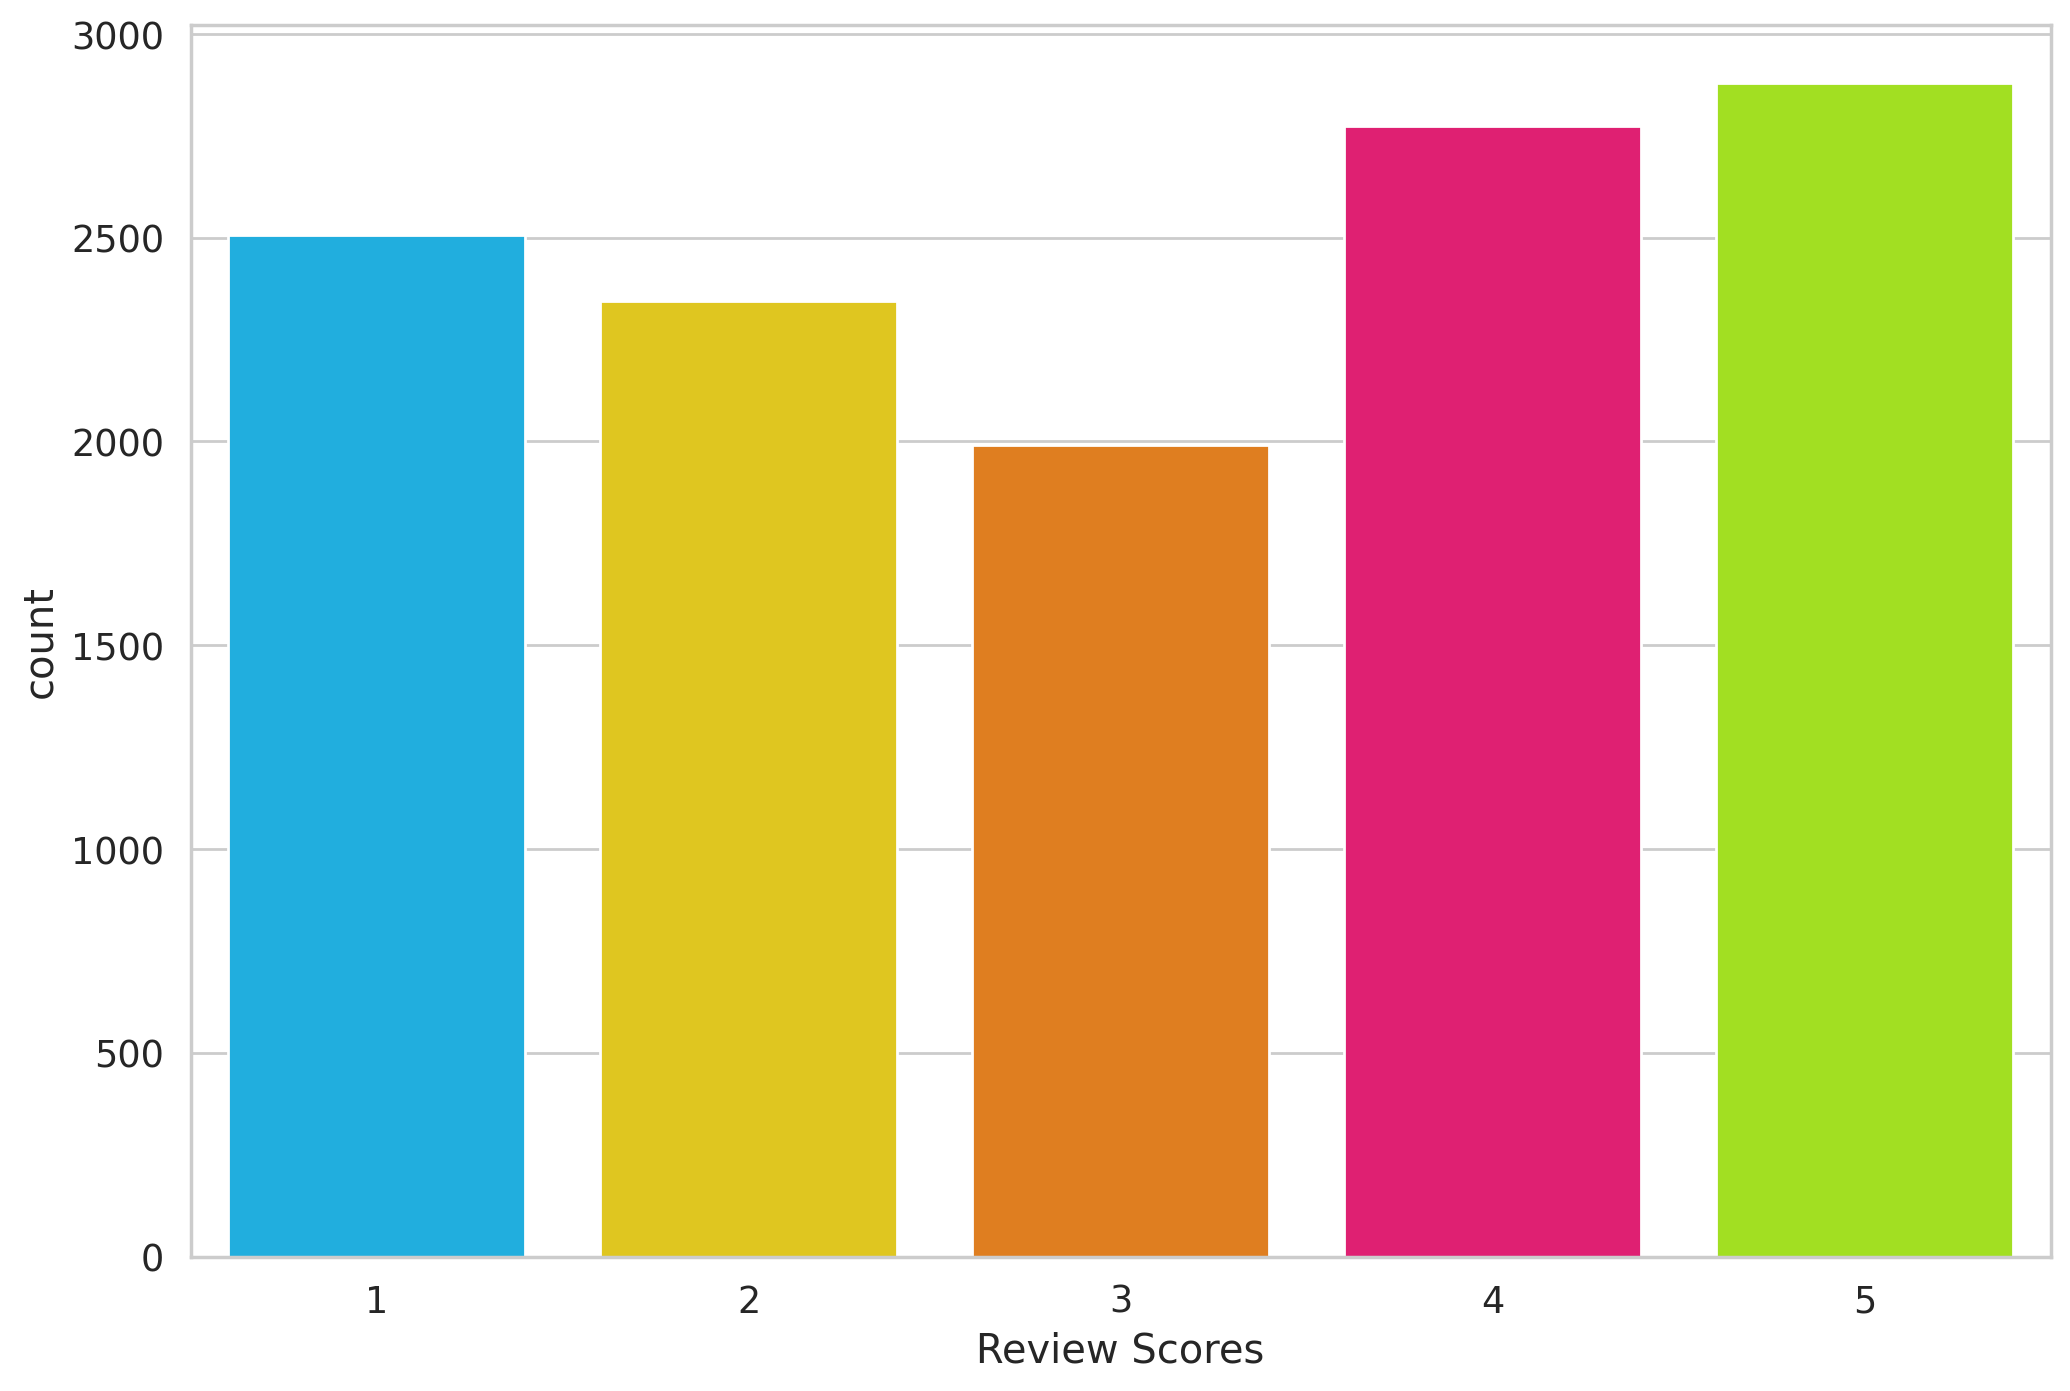

In [16]:
sns.countplot(x="score", data=df, palette=HAPPY_COLORS_PALETTE)
plt.xlabel("Review Scores")

In [17]:
def to_sentiment(rating):
    rating = int(rating)
    if rating<=2:
        return 0
    elif rating==3:
        return 1
    else:
        return 2

df["sentiment"] = df.score.apply(to_sentiment)

In [18]:
df.sentiment.value_counts()

sentiment
2    5654
0    4850
1    1991
Name: count, dtype: int64

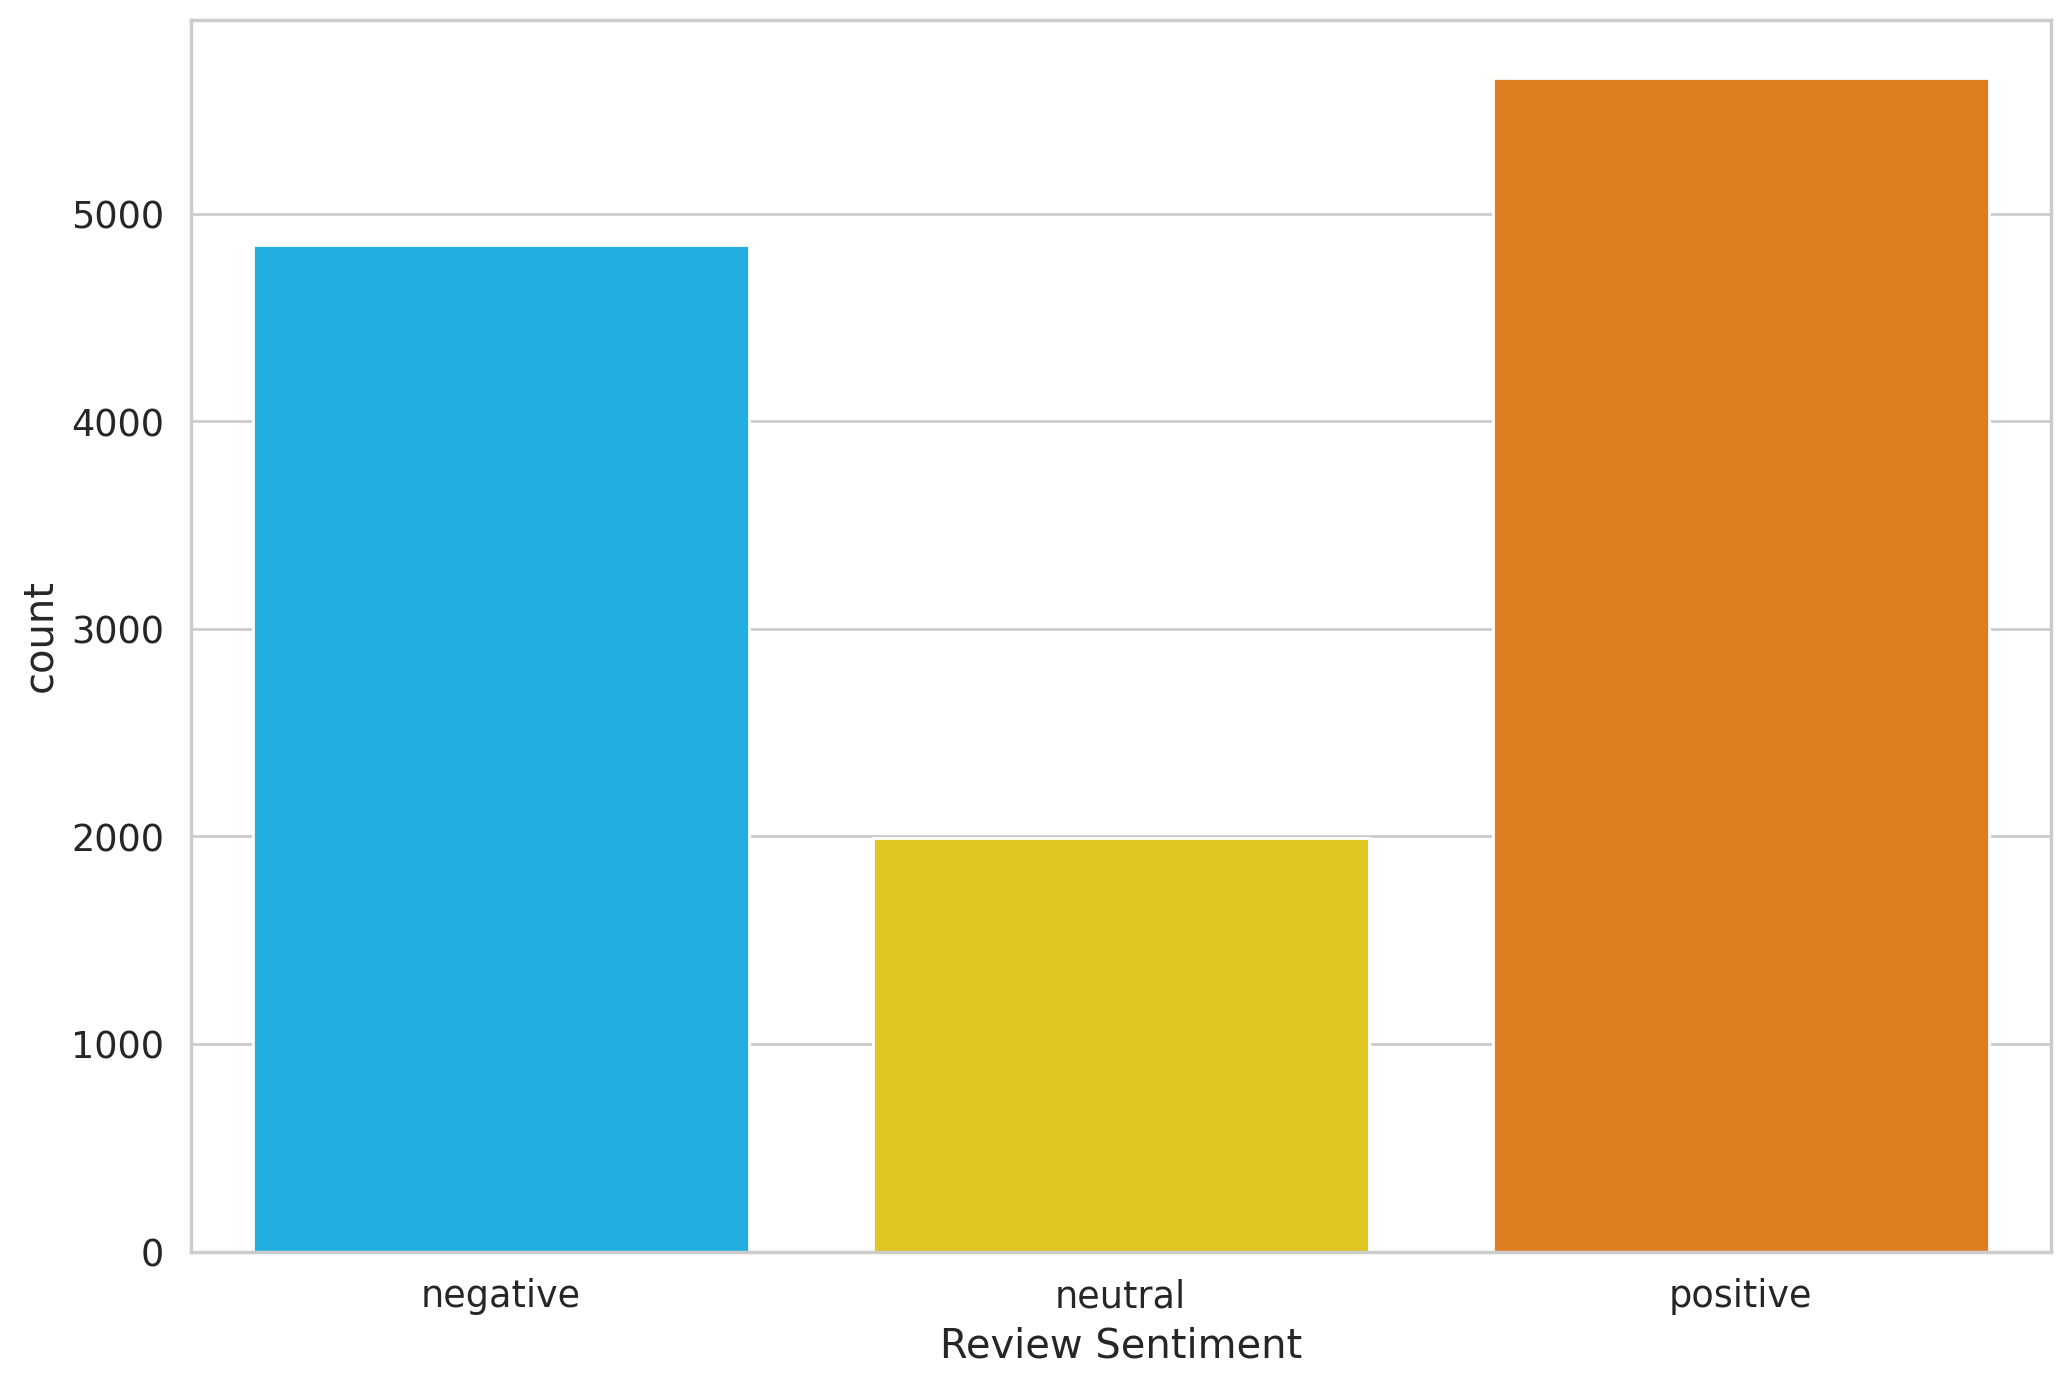

In [19]:
class_names = ["negative", "neutral", "positive"]
ax = sns.countplot(x="sentiment", data=df, palette=HAPPY_COLORS_PALETTE)
plt.xlabel("Review Sentiment")
ax.set_xticklabels(class_names)
plt.show()

In [20]:
MODEL_NAME = "bert-base-cased"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [21]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)


[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100
[MASK] 103


In [22]:
token_lens = []
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


Text(0.5, 16.044444444444423, 'Token Length')

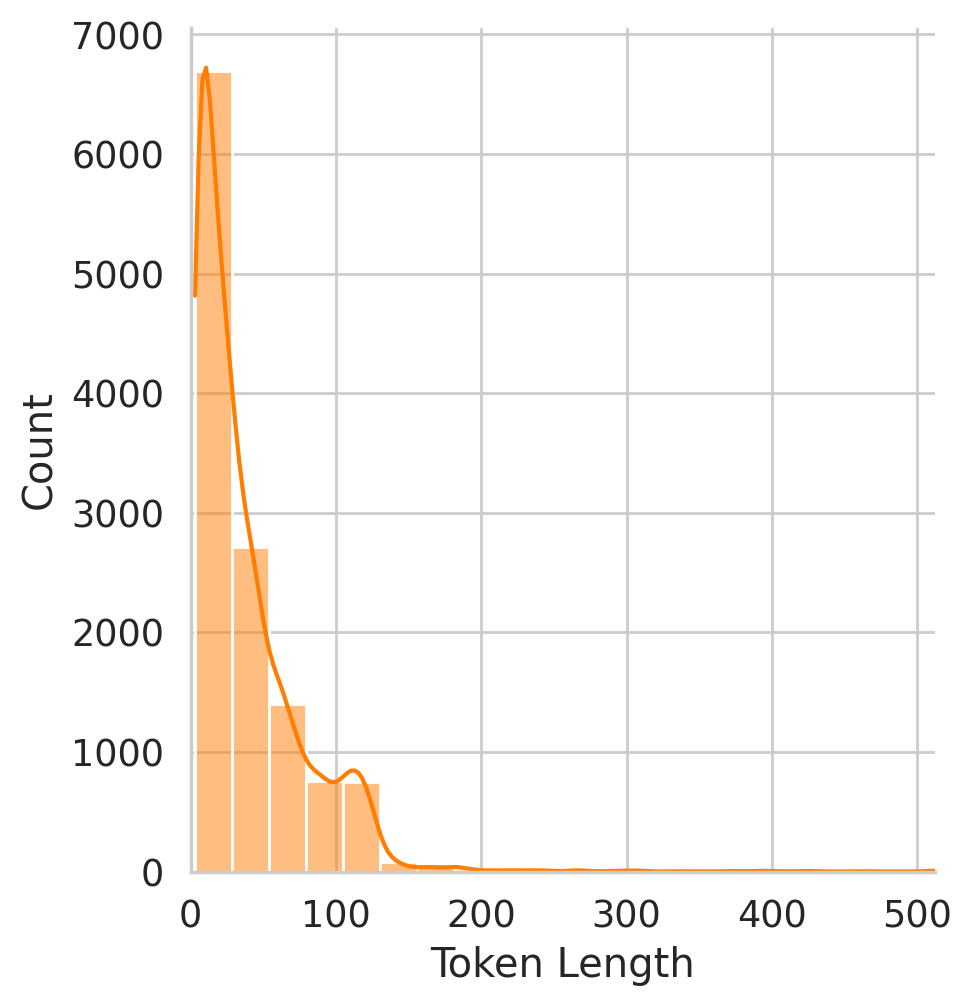

In [23]:
sns.displot(token_lens, bins=20, kde=True, color=HAPPY_COLORS_PALETTE[2])
plt.xlim(0, 512)
plt.xlabel("Token Length")

In [24]:
MAX_LEN = 160

class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            'review_text': review,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(target, dtype=torch.long)
        }
    

In [25]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(9996, 13) (1249, 13) (1250, 13)


In [26]:
def create_dataloader(df, tokenizer, max_len=MAX_LEN, batch_size=16, shuffle=False):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0, # 0 stands for no multiprocessing
        shuffle=shuffle
    )

In [27]:
BATCH_SIZE = 16
train_dataloader = create_dataloader(df_train, tokenizer, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = create_dataloader(df_val, tokenizer, batch_size=BATCH_SIZE)
test_dataloader = create_dataloader(df_test, tokenizer, batch_size=BATCH_SIZE)

print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

625 79 79


In [28]:
data = next(iter(train_dataloader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [29]:
bert_model = BertModel.from_pretrained(MODEL_NAME)
bert_model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [30]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)

        for name, param in self.bert.named_parameters():
            if name.startswith("encoder.layer.") and int(name.split(".")[2]) < 6:
                param.requires_grad = False
        
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [31]:
model = SentimentClassifier(n_classes=len(class_names))
model.to(device)


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [32]:
EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [33]:
def train_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.to(device)
    model.train()

    correct_predictions = 0
    losses = []
    
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        losses.append(loss.item()) 
        
        correct_predictions += torch.sum(preds == targets) 
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def eval_model(
    model,
    dataloader,
    loss_fn,
    device,
    n_examples
):
    model = model.to(device)
    model.eval()
    
    losses = []
    correct_predictions = 0 
    
    with torch.no_grad():  
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Validation loss {val_loss} accuracy {val_acc}")

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.5443069407939911 accuracy 0.7794117647058824
Validation loss 0.5860493401937847 accuracy 0.7590072057646117
Epoch 3/10
----------
Train loss 0.44607920393943784 accuracy 0.8239295718287315
Validation loss 0.6323937935919701 accuracy 0.755004003202562
Epoch 4/10
----------
Train loss 0.3401607875406742 accuracy 0.8719487795118048
Validation loss 0.7442692314522176 accuracy 0.7445956765412329
Epoch 5/10
----------
Train loss 0.24892984722405673 accuracy 0.9080632252901161
Validation loss 0.855358436703682 accuracy 0.7373899119295436
Epoch 6/10
----------
Train loss 0.17493783724680542 accuracy 0.9389755902360944
Validation loss 0.9669125181964681 accuracy 0.7453963170536428
Epoch 7/10
----------
Train loss 0.13571175387650727 accuracy 0.9503801520608244
Validation loss 1.050488476889043 accuracy 0.7245796637309847
Epoch 8/10
----------
Train loss 0.1022876237468794 accuracy 0.9632853141256503
Validation loss 1.155720858917206 accuracy 0.7381905524419535

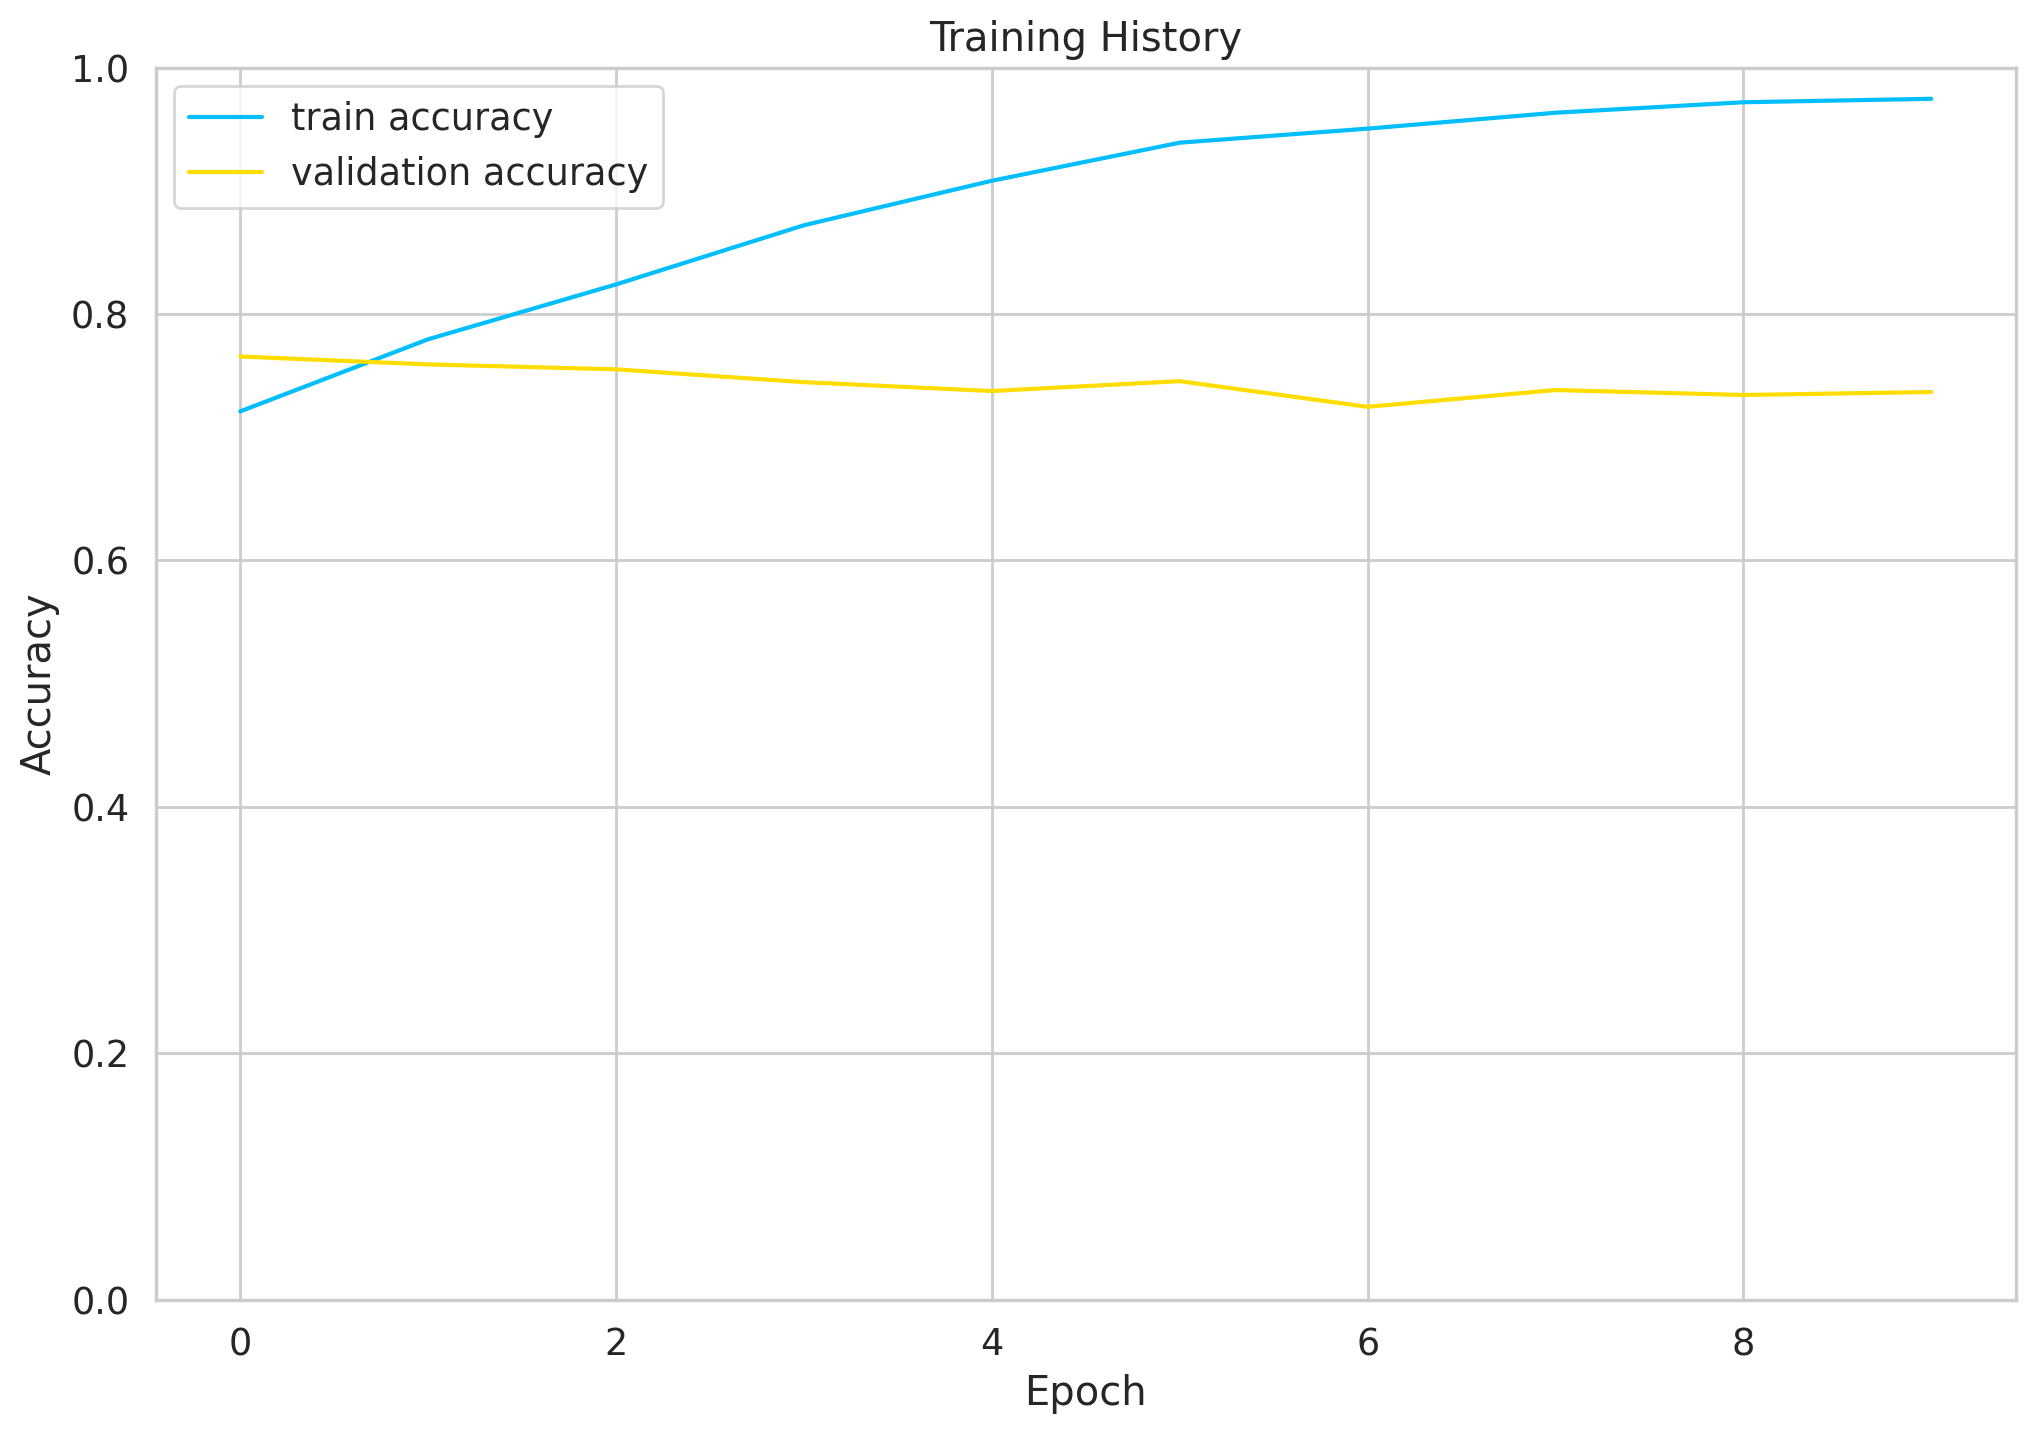

In [41]:
plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in history["train_acc"]], label="train accuracy")
plt.plot([x.cpu().numpy() if torch.is_tensor(x) else x for x in history["val_acc"]], label="validation accuracy")

plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [42]:
test_acc, _ = eval_model(
    model,
    test_dataloader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.7160000000000001

In [45]:
def get_predictions(model, dataloader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in dataloader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [46]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_dataloader
)

In [47]:
print(classification_report(y_test, y_pred, target_names =class_names))

              precision    recall  f1-score   support

    negative       0.75      0.76      0.76       480
     neutral       0.34      0.33      0.33       216
    positive       0.82      0.83      0.83       554

    accuracy                           0.72      1250
   macro avg       0.64      0.64      0.64      1250
weighted avg       0.71      0.72      0.71      1250



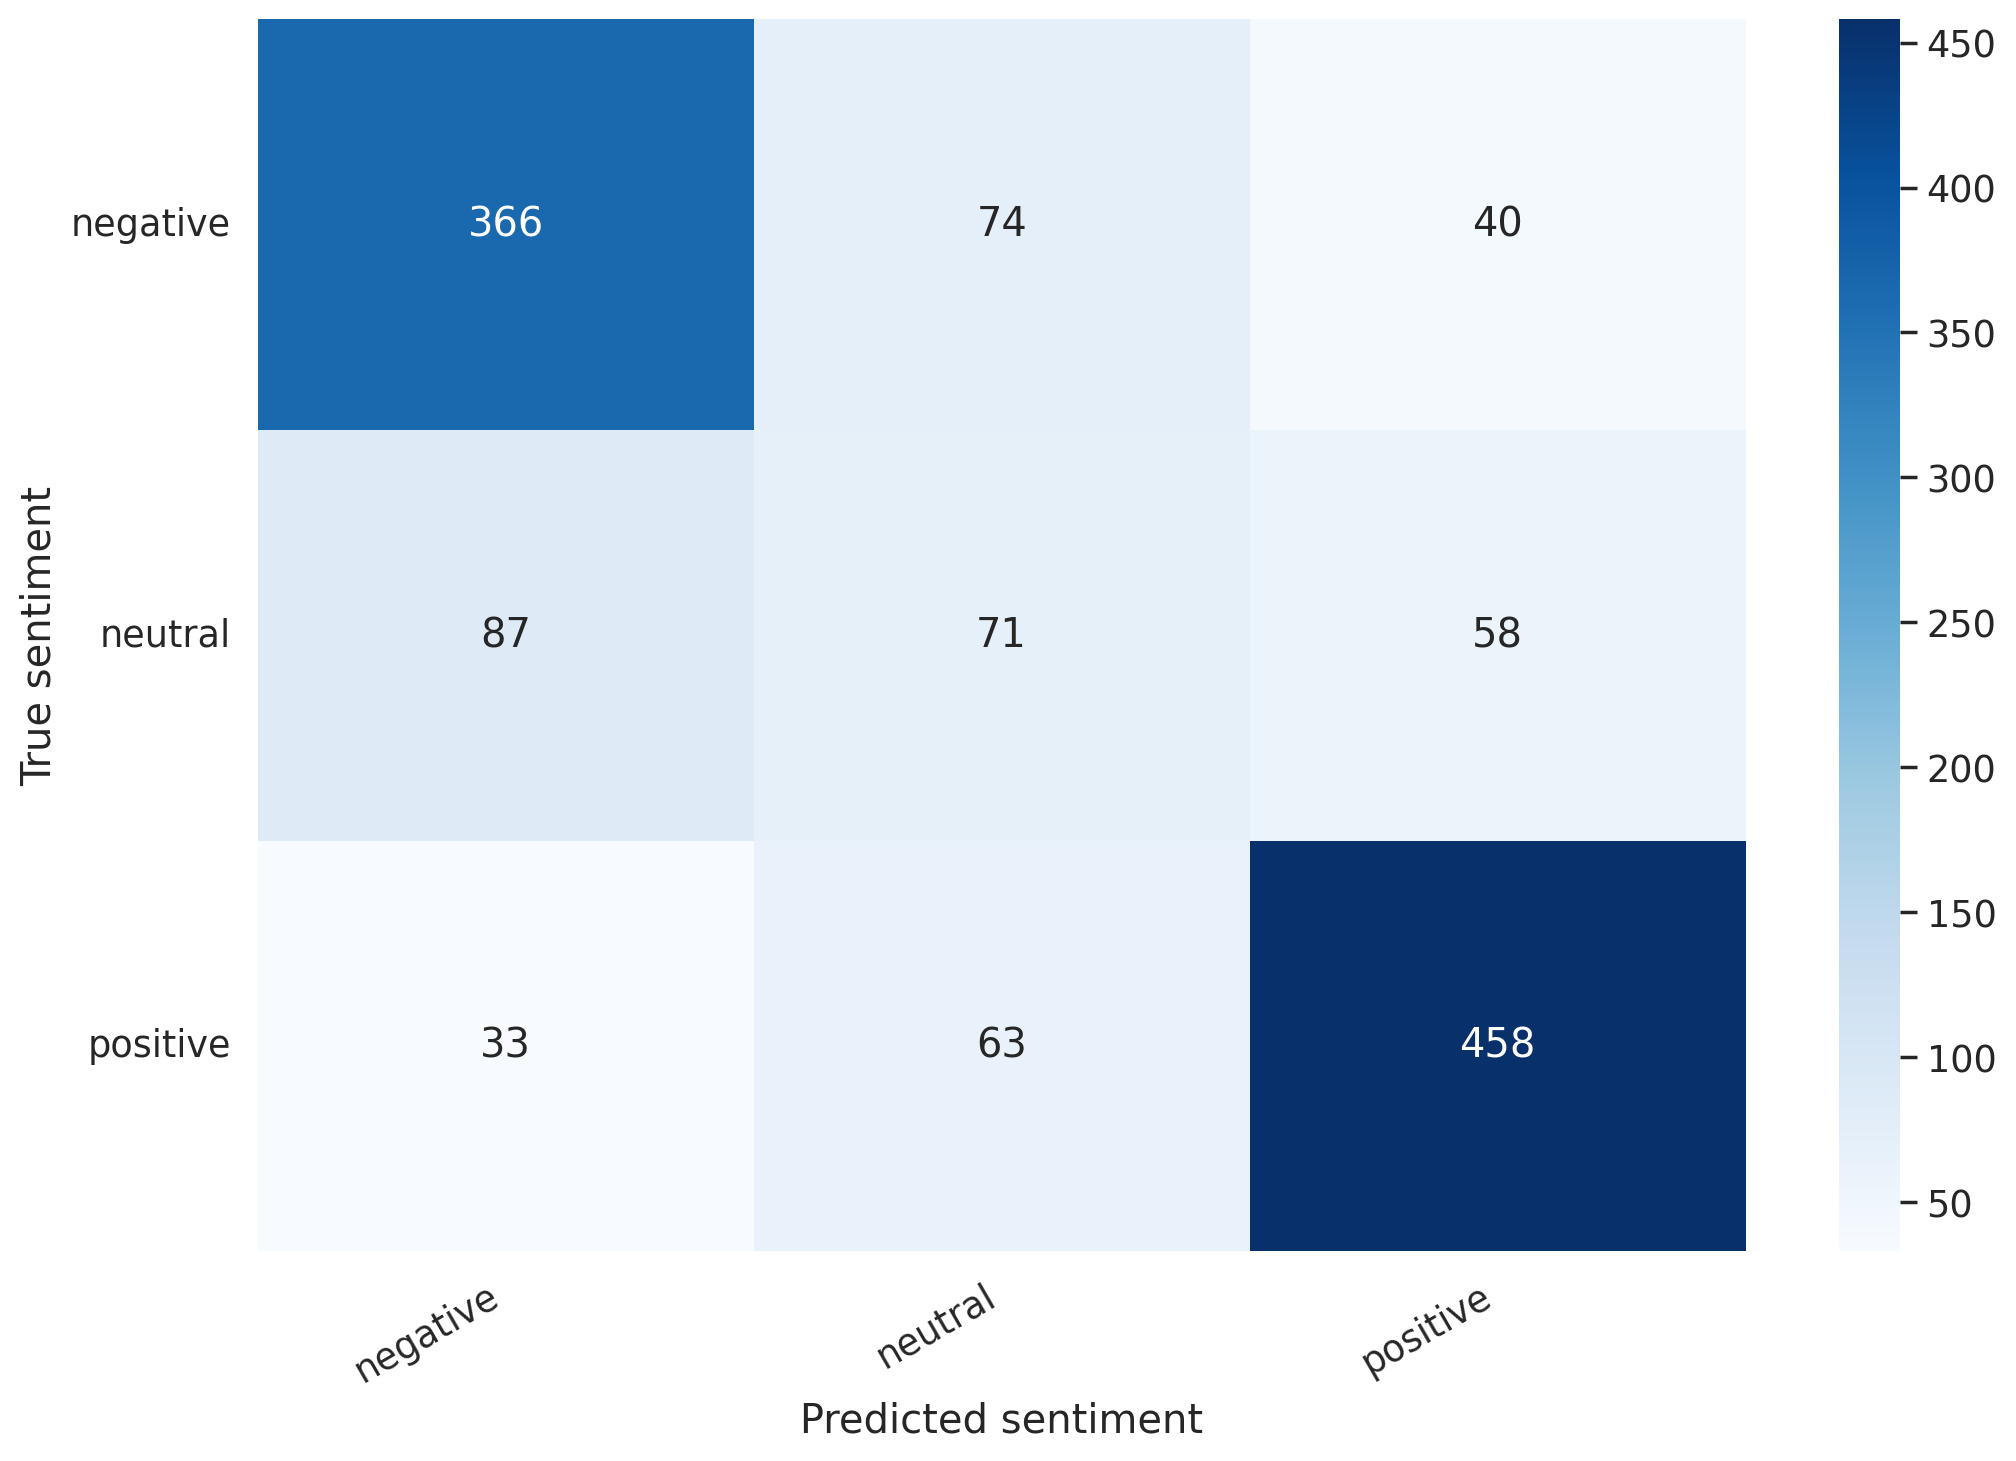

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [49]:
review_text = "Although I don't have any energy, thanks to this app, I can finish my todos."

In [50]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [54]:
encoded_review["input_ids"].shape

torch.Size([1, 160])

In [55]:
input_ids = encoded_review["input_ids"].to(device)
attention_mask = encoded_review["attention_mask"].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f"Review text: {review_text}")
print(f"Sentiment: {class_names[prediction]}")

Review text: Although I don't have any energy, thanks to this app, I can finish my todos.
Sentiment: positive
